In [1]:
import os
from pathlib import Path
DIR_HOME = Path(os.getcwd()).parent
DIR_CONV = DIR_HOME / "data" / "conversations"
DIR_STAT = DIR_HOME / "data" / "statistics"

import sys
sys.path.append(str(DIR_HOME))

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import json
import numpy as np
import pandas as pd
with open(DIR_CONV / "text-davinci-003-single-response.json") as f:
    responses = json.load(f)

import sqlalchemy
import mysql.connector as connection

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.utils import cohen_d, norm_diff_stdev
from src.metrics import SentenceBERTDiversity, Length
grp_metrics = [SentenceBERTDiversity("paraphrase-MiniLM-L3-v2")]
ind_metrics = [Length()]

In [2]:
for response in responses:
    for metric in grp_metrics:
        response[metric.name] = metric(response["completion"])[0]
    for metric in ind_metrics:
        response[metric.name] = metric(response["completion"])

df_responses = pd.DataFrame(responses).set_index(["qid", "cid"])
df_responses.head()

model  max_tokens                    stop  n  temperature  \
qid cid                                                                         
0   0    text-davinci-003         128  [Therapist:, Patient:]  8          1.0   
    1    text-davinci-003         128  [Therapist:, Patient:]  8          0.1   
    2    text-davinci-003         128  [Therapist:, Patient:]  8          0.5   
    3    text-davinci-003         128  [Therapist:, Patient:]  8          1.5   
    4    text-davinci-003         128  [Therapist:, Patient:]  8          1.0   

         top_p  frequency_penalty  presence_penalty  \
qid cid                                               
0   0      1.0                0.0               0.0   
    1      1.0                0.0               0.0   
    2      1.0                0.0               0.0   
    3      1.0                0.0               0.0   
    4      0.4                0.0               0.0   

                                                    prompt  \
qid cid                                                      
0   0    Below is a conversation between a patient and ...   
    1    Below is a conversation between a patient and ...   
    2    Below is a conversation between a patient and ...   
    3    Below is a conversation between a patient and ...   
    4    Below is a conversation between a patient and ...   

                                                 question  \
qid cid                                                     
0   0    How would you feel if someone called you a jerk?   
    1    How would you feel if someone called you a jerk?   
    2    How would you feel if someone called you a jerk?   
    3    How would you feel if someone called you a jerk?   
    4    How would you feel if someone called you a jerk?   

                                                completion  \
qid cid                                                      
0   0    [I would feel angry and disrespected. I think ...   
    1    [I would feel very hurt and angry. I would fee...   
    2    [I would feel very hurt and angry. I would fee...   
    3    [I would feel hurt and upset — likely to take ...   
    4    [I would feel embarrassed and ashamed. I would...   

         sentencebert_diversity                            length  
qid cid                                                            
0   0                  0.309150  [33, 41, 45, 44, 42, 43, 28, 50]  
    1                  0.084255  [29, 36, 29, 31, 41, 36, 29, 29]  
    2                  0.292966  [31, 32, 38, 24, 23, 37, 42, 32]  
    3                  0.407062  [25, 52, 59, 53, 30, 45, 48, 39]  
    4                  0.221068  [33, 43, 29, 35, 35, 29, 29, 28]

In [3]:
base_cid = 0
last_cid = 12
last_qid = 23

grp_stats = []
ind_stats = []

for cid in range((base_cid + 1), (last_cid + 1)):

    for metric in grp_metrics:
        val_base = df_responses.xs(base_cid, level="cid").loc[:, metric.name].values
        val_test = df_responses.xs(cid, level="cid").loc[:, metric.name].values
        grp_stats.append({"base_cfg": base_cid,
                          "test_cfg": cid,
                          "metric": metric.name,
                          "cohen_d": cohen_d(val_base, val_test),
                          "norm_diff_stdev": norm_diff_stdev(val_base, val_test)})

    for qid in range(last_qid + 1):
        for metric in ind_metrics:
            val_base = df_responses.xs((qid, base_cid), level=["qid", "cid"]).loc[:, metric.name].values[0]
            val_test = df_responses.xs((qid, cid), level=["qid", "cid"]).loc[:, metric.name].values[0]
            t_stats, p_val = ttest_ind(val_base, val_test)
            ind_stats.append({"base_cfg": base_cid,
                              "test_cfg": cid,
                              "qid": qid,
                              "metric": metric.name,
                              "cohen_d": cohen_d(val_base, val_test),
                              "norm_diff_stdev": norm_diff_stdev(val_base, val_test),
                              "t_stats": t_stats,
                              "p_val": p_val})

In [4]:
pd.DataFrame(grp_stats)

,base_cfg,test_cfg,metric,cohen_d,norm_diff_stdev
0,0,1,sentencebert_diversity,2.375071,0.255818
1,0,2,sentencebert_diversity,1.021291,0.146023
2,0,3,sentencebert_diversity,-1.006818,0.135542
3,0,4,sentencebert_diversity,1.443739,0.025210
4,0,5,sentencebert_diversity,0.895206,0.061441
5,0,6,sentencebert_diversity,0.611165,0.041811
6,0,7,sentencebert_diversity,-0.035742,0.054867
7,0,8,sentencebert_diversity,-0.141855,0.029493
8,0,9,sentencebert_diversity,-0.185723,0.013732
9,0,10,sentencebert_diversity,0.056167,0.078281


In [5]:
pd.DataFrame(ind_stats)

,base_cfg,test_cfg,qid,metric,cohen_d,norm_diff_stdev,t_stats,p_val
0,0,1,0,length,1.392375,0.406230,2.784750,0.014612
1,0,1,1,length,2.493999,0.530689,4.987998,0.000199
2,0,1,2,length,-0.089211,0.692073,-0.178422,0.860948
3,0,1,3,length,1.024154,0.541975,2.048307,0.059765
4,0,1,4,length,-0.646181,0.574595,-1.292363,0.217156
...,...,...,...,...,...,...,...,...
283,0,12,19,length,-0.567204,-0.316047,-1.134408,0.275674
284,0,12,20,length,-0.095164,-0.727292,-0.190327,0.851785
285,0,12,21,length,-0.433698,-0.164585,-0.867396,0.400348
286,0,12,22,length,0.549720,0.141331,1.099440,0.290123


## __Compute LIWC2015 Metrics with `DLATK`__

In [6]:
# table_name = "davinci_single_response"
# df_responses = pd.DataFrame(responses) \
#                     .rename(columns={"completion": "message"}) \
#                     .loc[:, ["qid", "cid", "message"]] \
#                     .explode("message")

# sql_drop_table = f"""DROP TABLE IF EXISTS {table_name};"""
# sql_create_table = f"""
# CREATE TABLE {table_name} (
#     message_id INT(11) NOT NULL AUTO_INCREMENT PRIMARY KEY,
#     qid INT(10) UNSIGNED NOT NULL,
#     cid INT(10) UNSIGNED NOT NULL,
#     message TEXT
# );
# """

# cnx = connection.connect(host="localhost",
#                          database="wangy49",
#                          user="wangy49")
# cursor = cnx.cursor()

# # Create a SQLAlchemy engine from the MySQL connection
# engine = sqlalchemy.create_engine('mysql+mysqlconnector://', creator=lambda: cnx)

# cursor.execute(sql_drop_table)
# cursor.execute(sql_create_table)
# cnx.commit()

# df_responses.to_sql(table_name, 
#                     con=engine, 
#                     if_exists="append", 
#                     index=False)

# cnx.close()

In [7]:
# !sudo service mysql start
# !mysqldump -u wangy49 wangy49 > ../db/wangy49.sql
# ~/dlatkInterface.py \
#     -d wangy49 \
#     -t davinci_single_response \
#     -g message_id \
#     --add_ngrams -n 1 \
# && \
# ~/dlatkInterface.py \
#     -d wangy49 \
#     -t davinci_single_response \
#     -g message_id \
#     --add_lex_table -l LIWC2015 \
# &

# python scripts/export_table_from_db.py \
#   -d wangy49 \
#   -t davinci_single_response_liwc \
#   -o text_davinci_003_single_response_liwc.csv

"""
DROP TABLE IF EXISTS davinci_single_response_liwc; 
CREATE TABLE davinci_single_response_liwc AS 
    SELECT 
        message_id, 
        qid, 
        cid, 
        feat, 
        value, 
        group_norm 
    FROM 
        feat$cat_LIWC2015$davinci_single_response$message_id$1gra AS f 
        INNER JOIN (SELECT qid, cid, message_id FROM davinci_single_response) AS i 
        ON f.group_id = i.message_id;
"""

# !scp wangy49@grande.wwbp.org:~/decoding_param/text_davinci_003_single_response_liwc.csv .               

'\nDROP TABLE IF EXISTS davinci_single_response_liwc; \nCREATE TABLE davinci_single_response_liwc AS \n    SELECT \n        message_id, \n        qid, \n        cid, \n        feat, \n        value, \n        group_norm \n    FROM \n        feat$cat_LIWC2015$davinci_single_response$message_id$1gra AS f \n        INNER JOIN (SELECT qid, cid, message_id FROM davinci_single_response) AS i \n        ON f.group_id = i.message_id;\n'

In [8]:
feat_keep = {"FEEL", "NEGEMO", "POSEMO", "SAD", "SOCIAL"}
df_liwc_stats = pd.read_csv(DIR_STAT / "text_davinci_003_single_response_liwc.csv")
df_liwc_stats = (df_liwc_stats
                     .loc[df_liwc_stats.feat.isin(feat_keep), :]
                     .copy()
                     .pivot(index=["message_id", "qid", "cid"],
                            columns="feat",
                            values="group_norm")
                     .fillna(np.finfo(float).eps) 
                     .reset_index()
                     .set_index("message_id")
                     .groupby(["qid", "cid"])
                     .agg(list))
df_liwc_stats.head()

feat                                                  FEEL  \
qid cid                                                      
0   0    [0.111111111111111, 0.0454545454545454, 0.0833...   
    1    [0.125, 0.128205128205128, 0.125, 0.1176470588...   
    2    [0.11764705882353, 0.114285714285714, 0.073170...   
    3    [0.076923076923077, 0.0363636363636364, 0.0153...   
    4    [0.0555555555555556, 0.108695652173913, 0.0937...   

feat                                                NEGEMO  \
qid cid                                                      
0   0    [0.138888888888889, 0.0681818181818181, 0.0833...   
    1    [0.09375, 0.0512820512820512, 0.09375, 0.05882...   
    2    [0.0588235294117648, 0.0857142857142858, 0.097...   
    3    [0.076923076923077, 0.0727272727272728, 0.0461...   
    4    [0.166666666666667, 0.108695652173913, 0.15625...   

feat                                                POSEMO  \
qid cid                                                      
0   0    [2.220446049250313e-16, 0.0454545454545454, 0....   
    1    [2.220446049250313e-16, 2.220446049250313e-16,...   
    2    [2.220446049250313e-16, 0.0285714285714286, 2....   
    3    [0.0384615384615385, 2.220446049250313e-16, 2....   
    4    [2.220446049250313e-16, 2.220446049250313e-16,...   

feat                                                   SAD  \
qid cid                                                      
0   0    [0.0555555555555556, 0.0227272727272727, 0.020...   
    1    [0.03125, 0.0256410256410256, 0.03125, 0.02941...   
    2    [0.0294117647058824, 0.0285714285714286, 0.024...   
    3    [0.0384615384615385, 2.220446049250313e-16, 2....   
    4    [2.220446049250313e-16, 0.0217391304347826, 2....   

feat                                                SOCIAL  
qid cid                                                     
0   0    [0.0277777777777778, 0.0681818181818181, 0.125...  
    1    [2.220446049250313e-16, 2.220446049250313e-16,...  
    2    [2.220446049250313e-16, 0.114285714285714, 0.1...  
    3    [0.076923076923077, 0.109090909090909, 0.09230...  
    4    [0.138888888888889, 0.130434782608696, 0.03125...

In [9]:
base_cid = 0
last_cid = 12
last_qid = 23

liwc_stats = []
for cid in range((base_cid + 1), (last_cid + 1)):
    for qid in range(last_qid + 1):
        for feat in feat_keep:
            val_base = df_liwc_stats.xs((qid, base_cid), level=["qid", "cid"]).loc[:, feat].values[0]
            val_test = df_liwc_stats.xs((qid, cid), level=["qid", "cid"]).loc[:, feat].values[0]
            t_stats, p_val = ttest_ind(val_base, val_test)
            liwc_stats.append({"base_cfg": base_cid,
                               "test_cfg": cid,
                               "qid": qid,
                               "metric": feat,
                               "cohen_d": cohen_d(val_base, val_test),
                               "norm_diff_stdev": norm_diff_stdev(val_base, val_test),
                               "t_stats": t_stats,
                               "p_val": p_val})
df_liwc_test = pd.DataFrame(liwc_stats) \
                .sort_values(["test_cfg", "metric", "qid"]) \
                .reset_index(drop=True) \
                .round(4) \
                .dropna()

# Correct for multiple comparisons using Benjamini-Hochberg procedure
df_liwc_test["p_val_adj"] = df_liwc_test \
                                .groupby(["test_cfg", "metric"])["p_val"] \
                                .transform(lambda x: multipletests(x, method="fdr_bh")[1])

In [10]:
df_liwc_test.head(50)

,base_cfg,test_cfg,qid,metric,cohen_d,norm_diff_stdev,t_stats,p_val,p_val_adj
0,0,1,0,FEEL,-2.9765,1.0841,-5.9529,0.0000,0.000000
1,0,1,1,FEEL,0.2420,1.1060,0.4840,0.6359,0.726743
2,0,1,2,FEEL,0.8768,0.4365,1.7536,0.1014,0.243360
3,0,1,3,FEEL,1.0102,1.4142,2.0204,0.0629,0.167733
4,0,1,4,FEEL,0.0616,0.4142,0.1233,0.9037,0.903700
5,0,1,5,FEEL,0.0788,0.7797,0.1576,0.8771,0.903700
6,0,1,6,FEEL,0.5720,-0.0384,1.1440,0.2718,0.407700
7,0,1,7,FEEL,-1.1231,-0.6991,-2.2461,0.0414,0.163543
8,0,1,8,FEEL,-0.4055,0.0888,-0.8110,0.4310,0.557811
9,0,1,9,FEEL,-1.8749,-0.1023,-3.7497,0.0022,0.013200


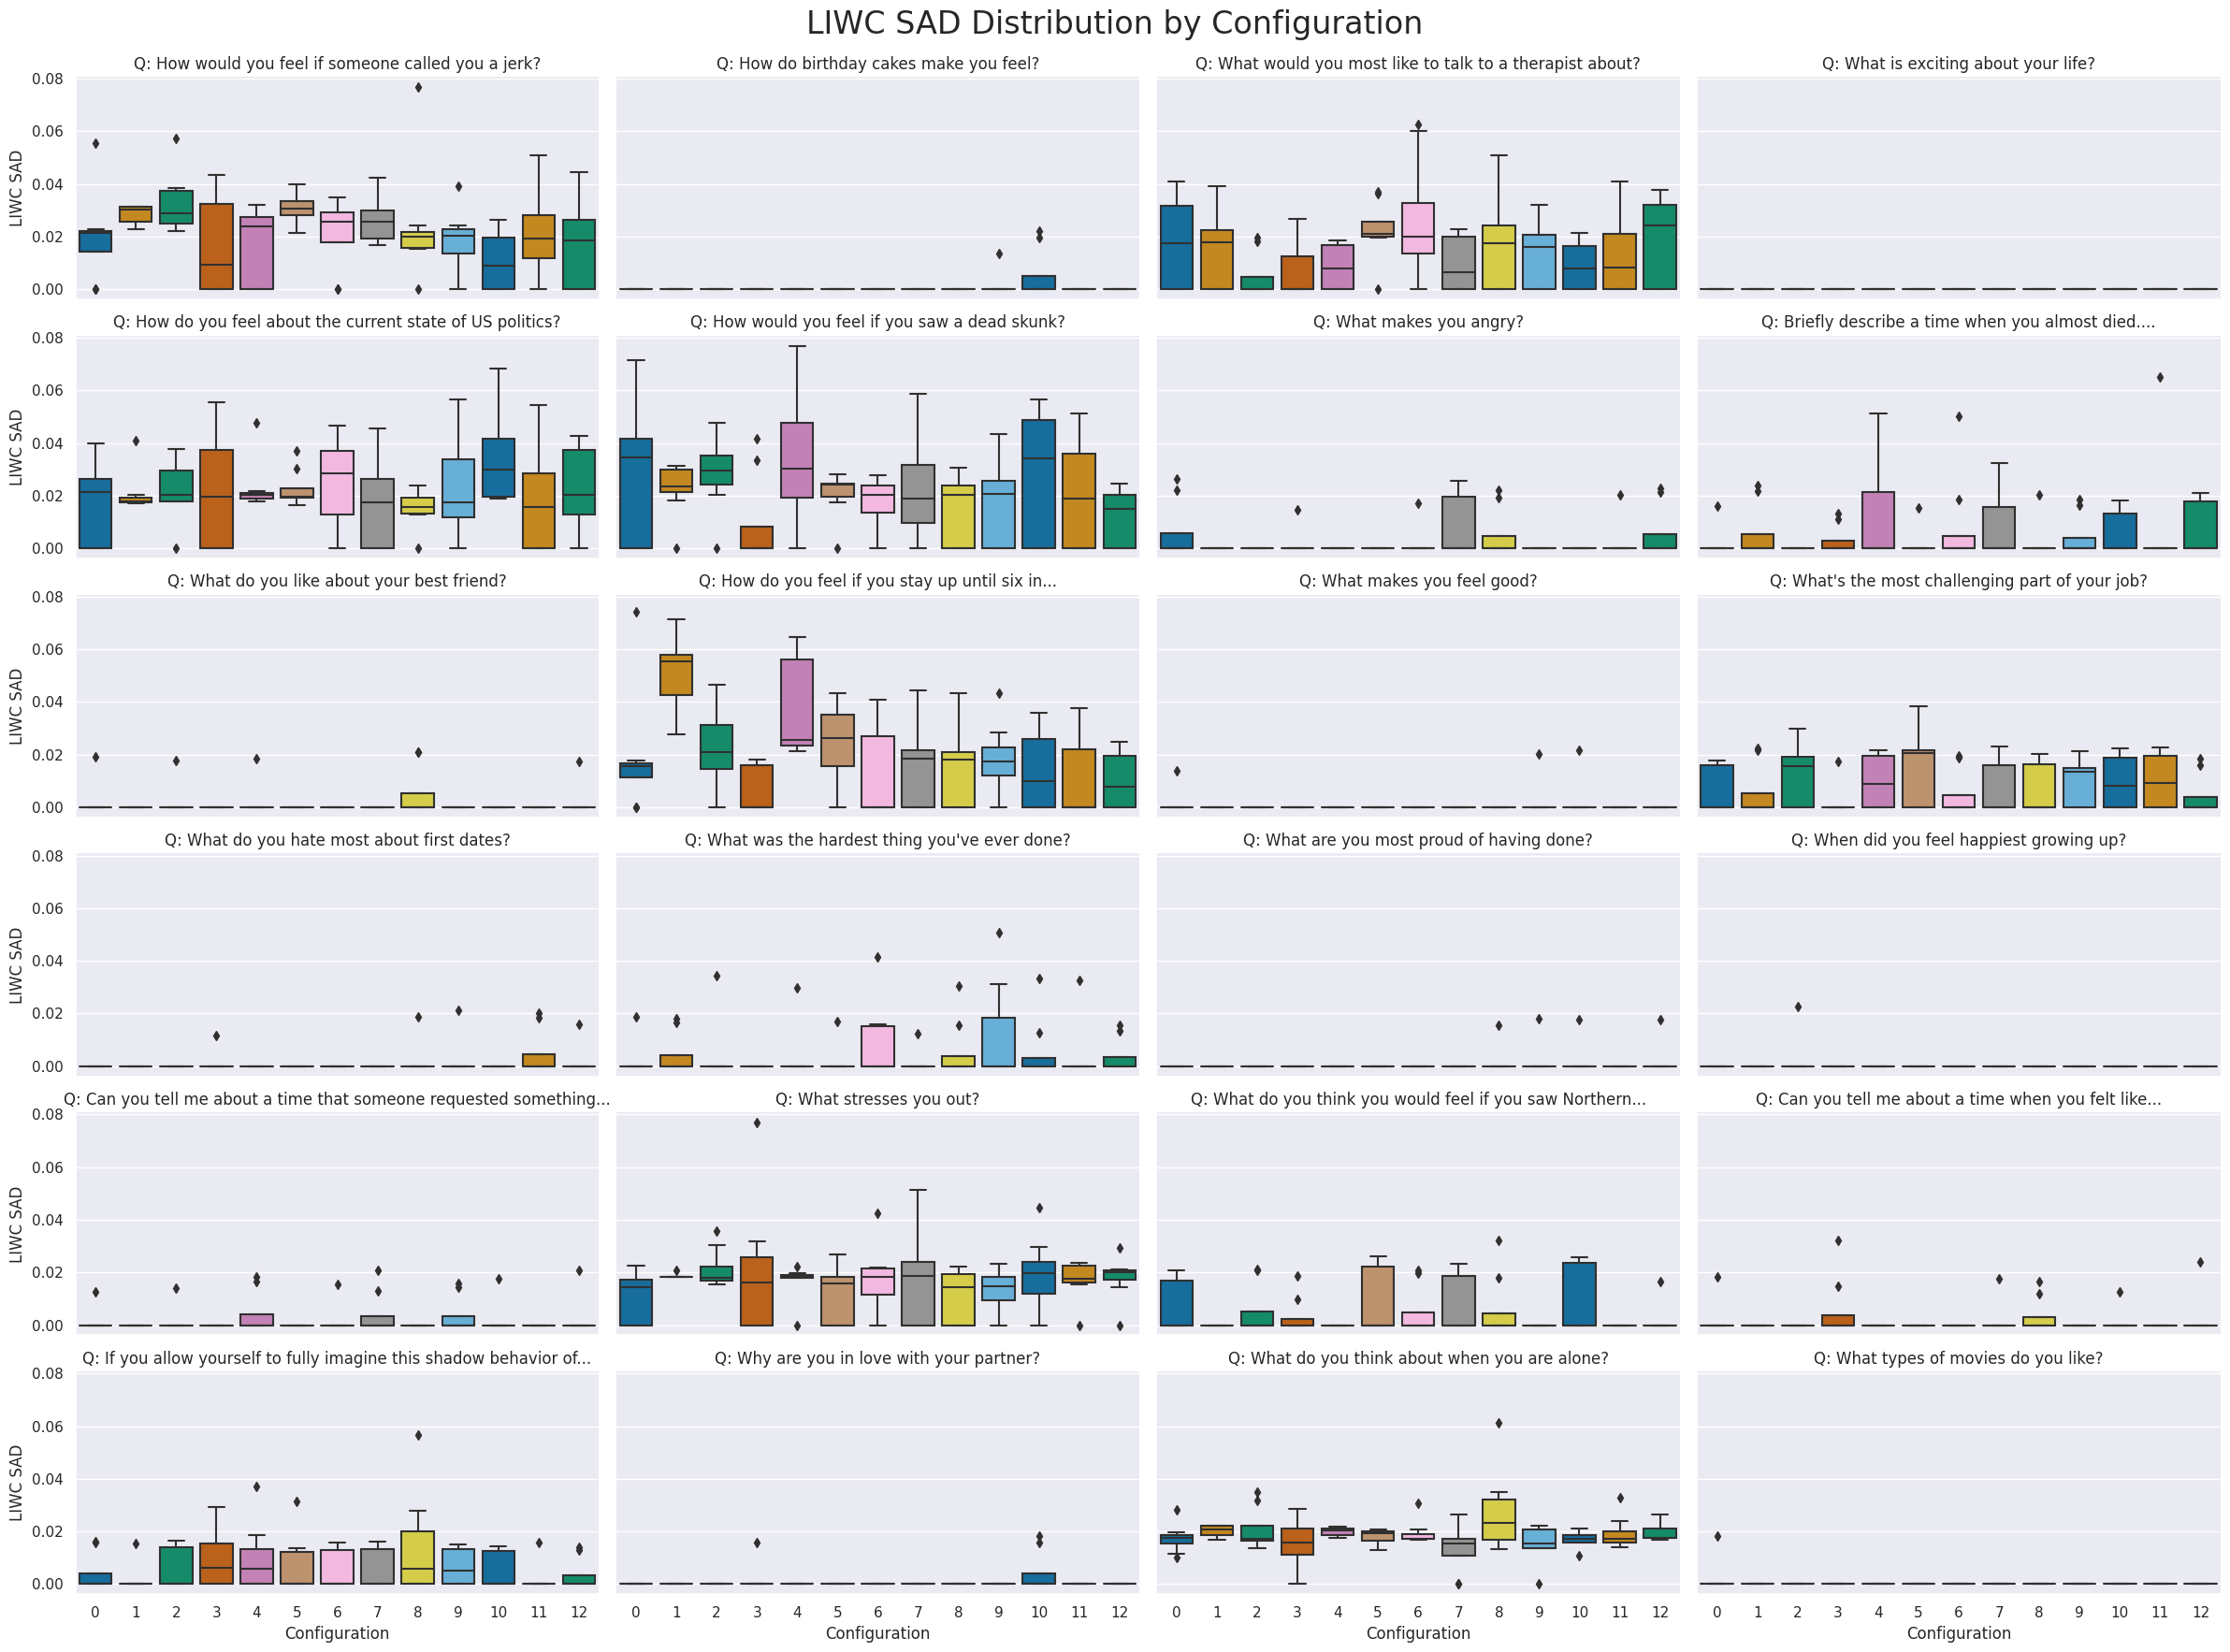

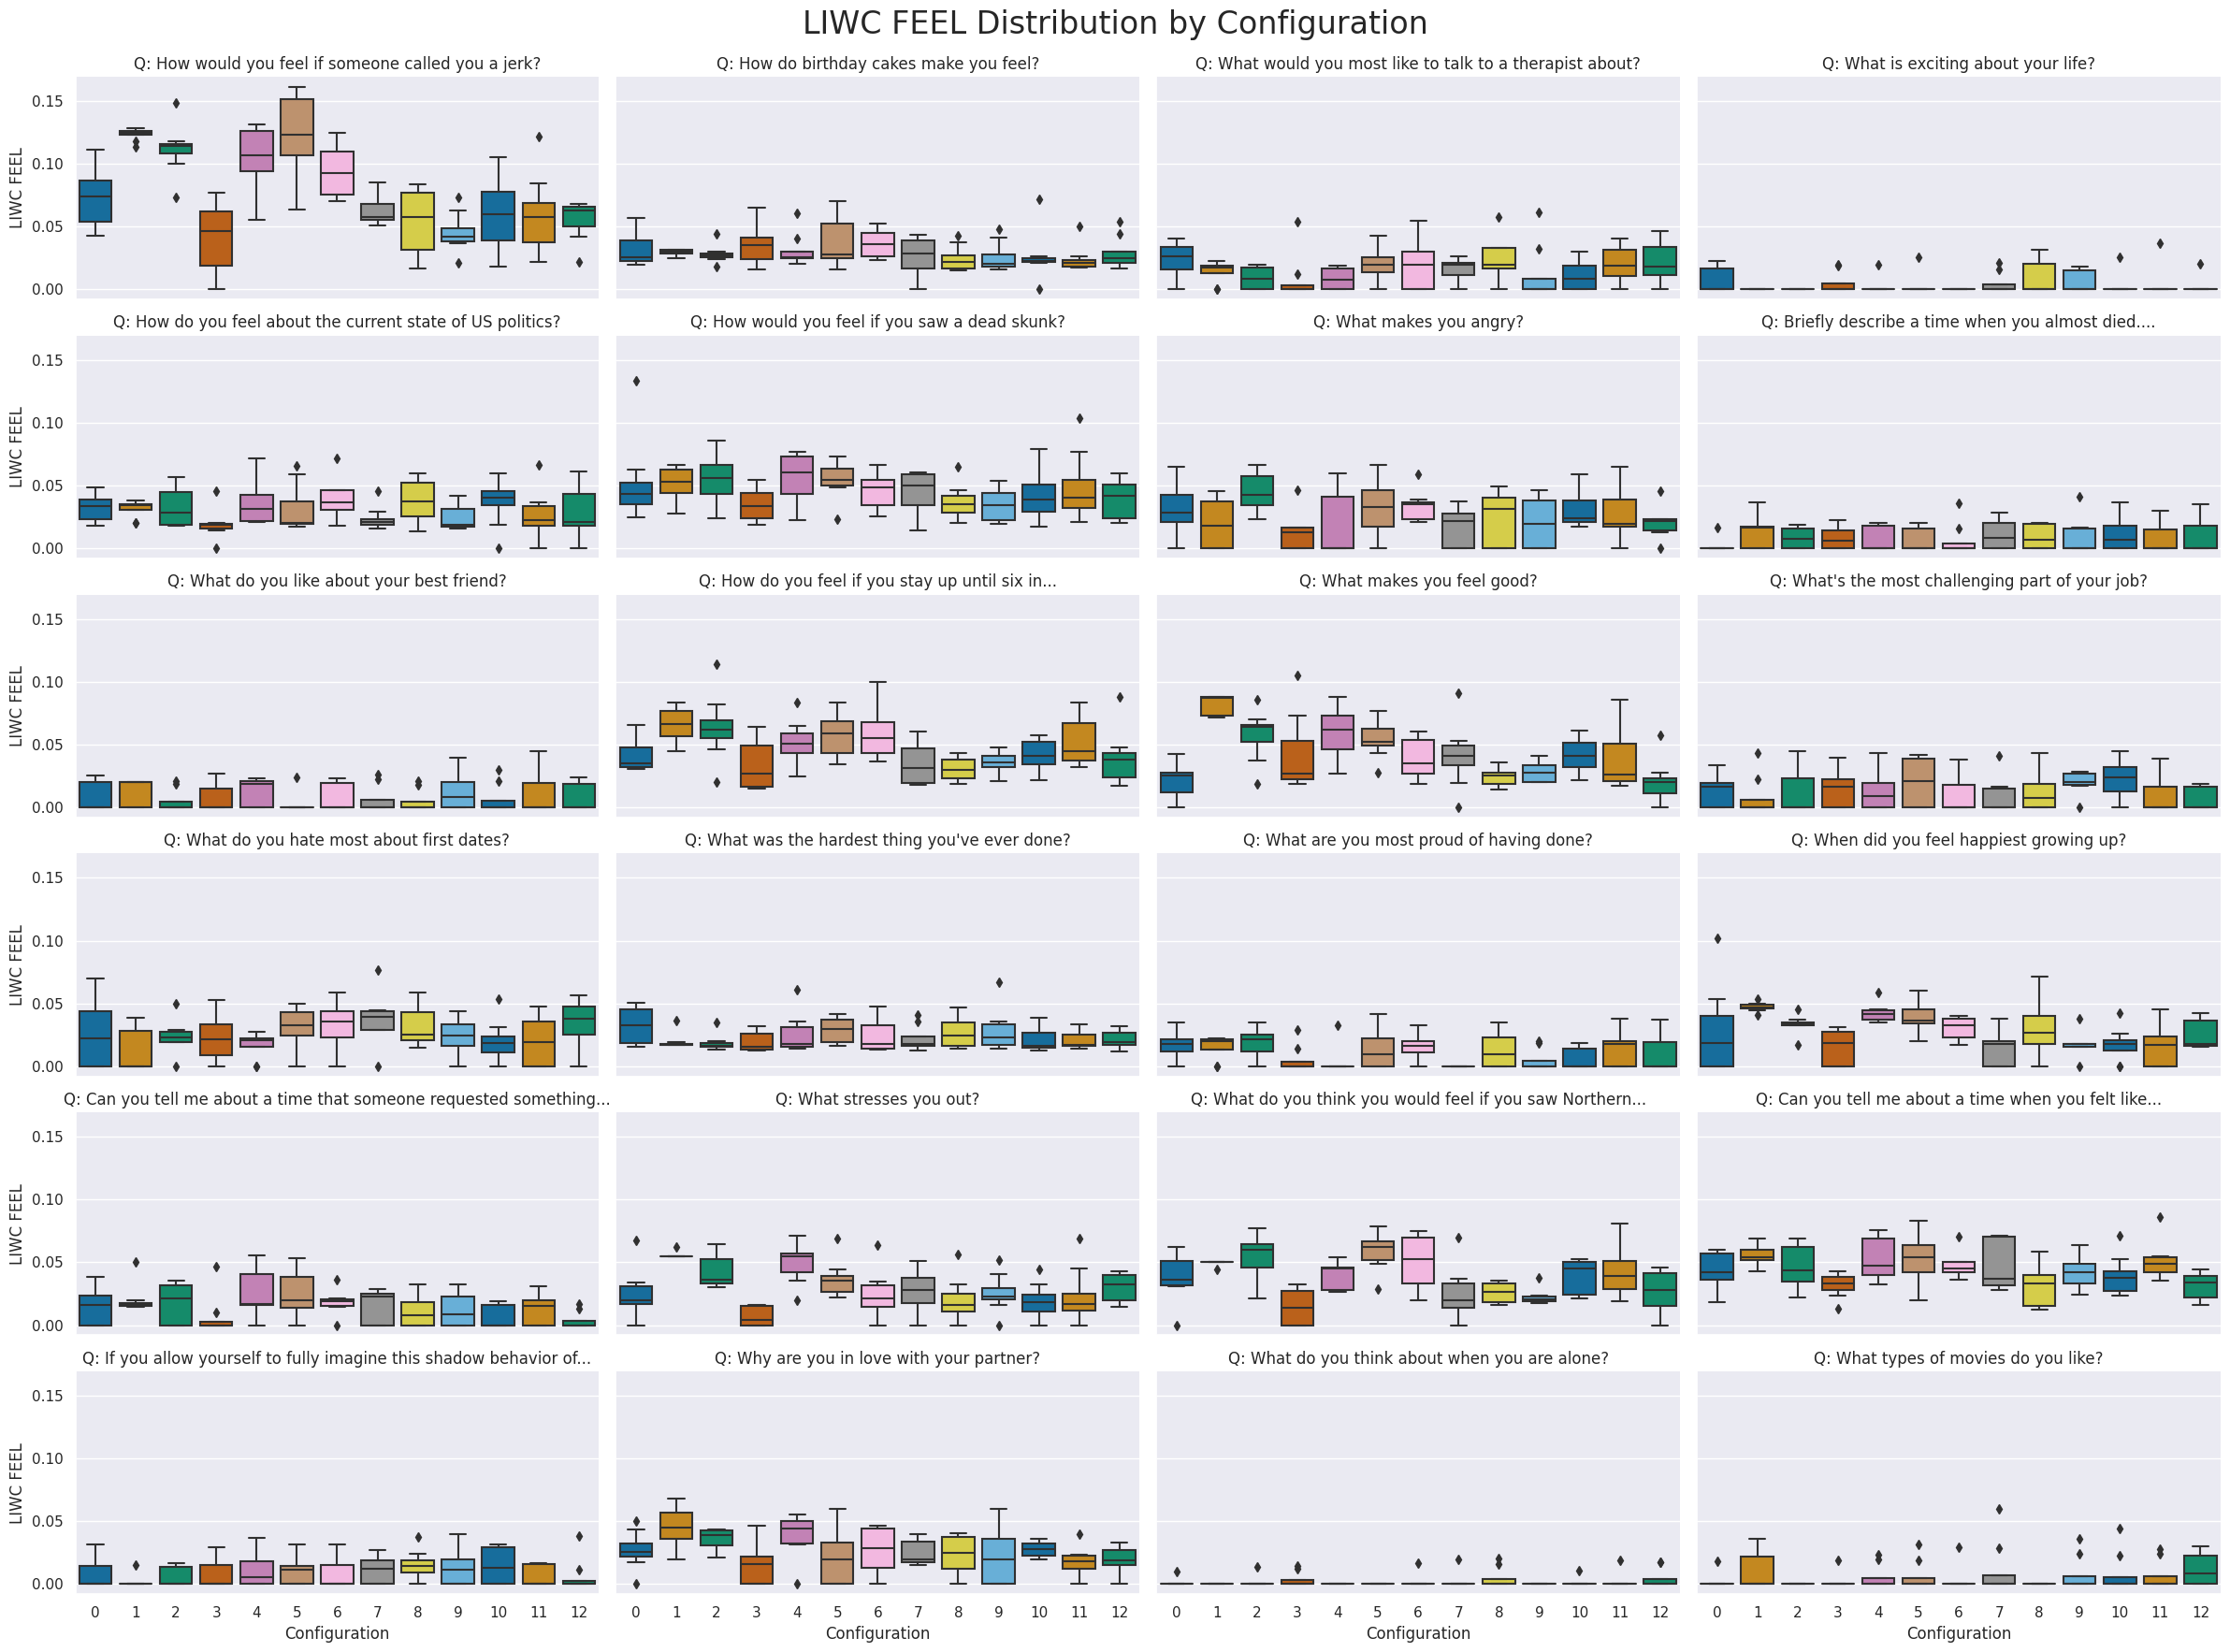

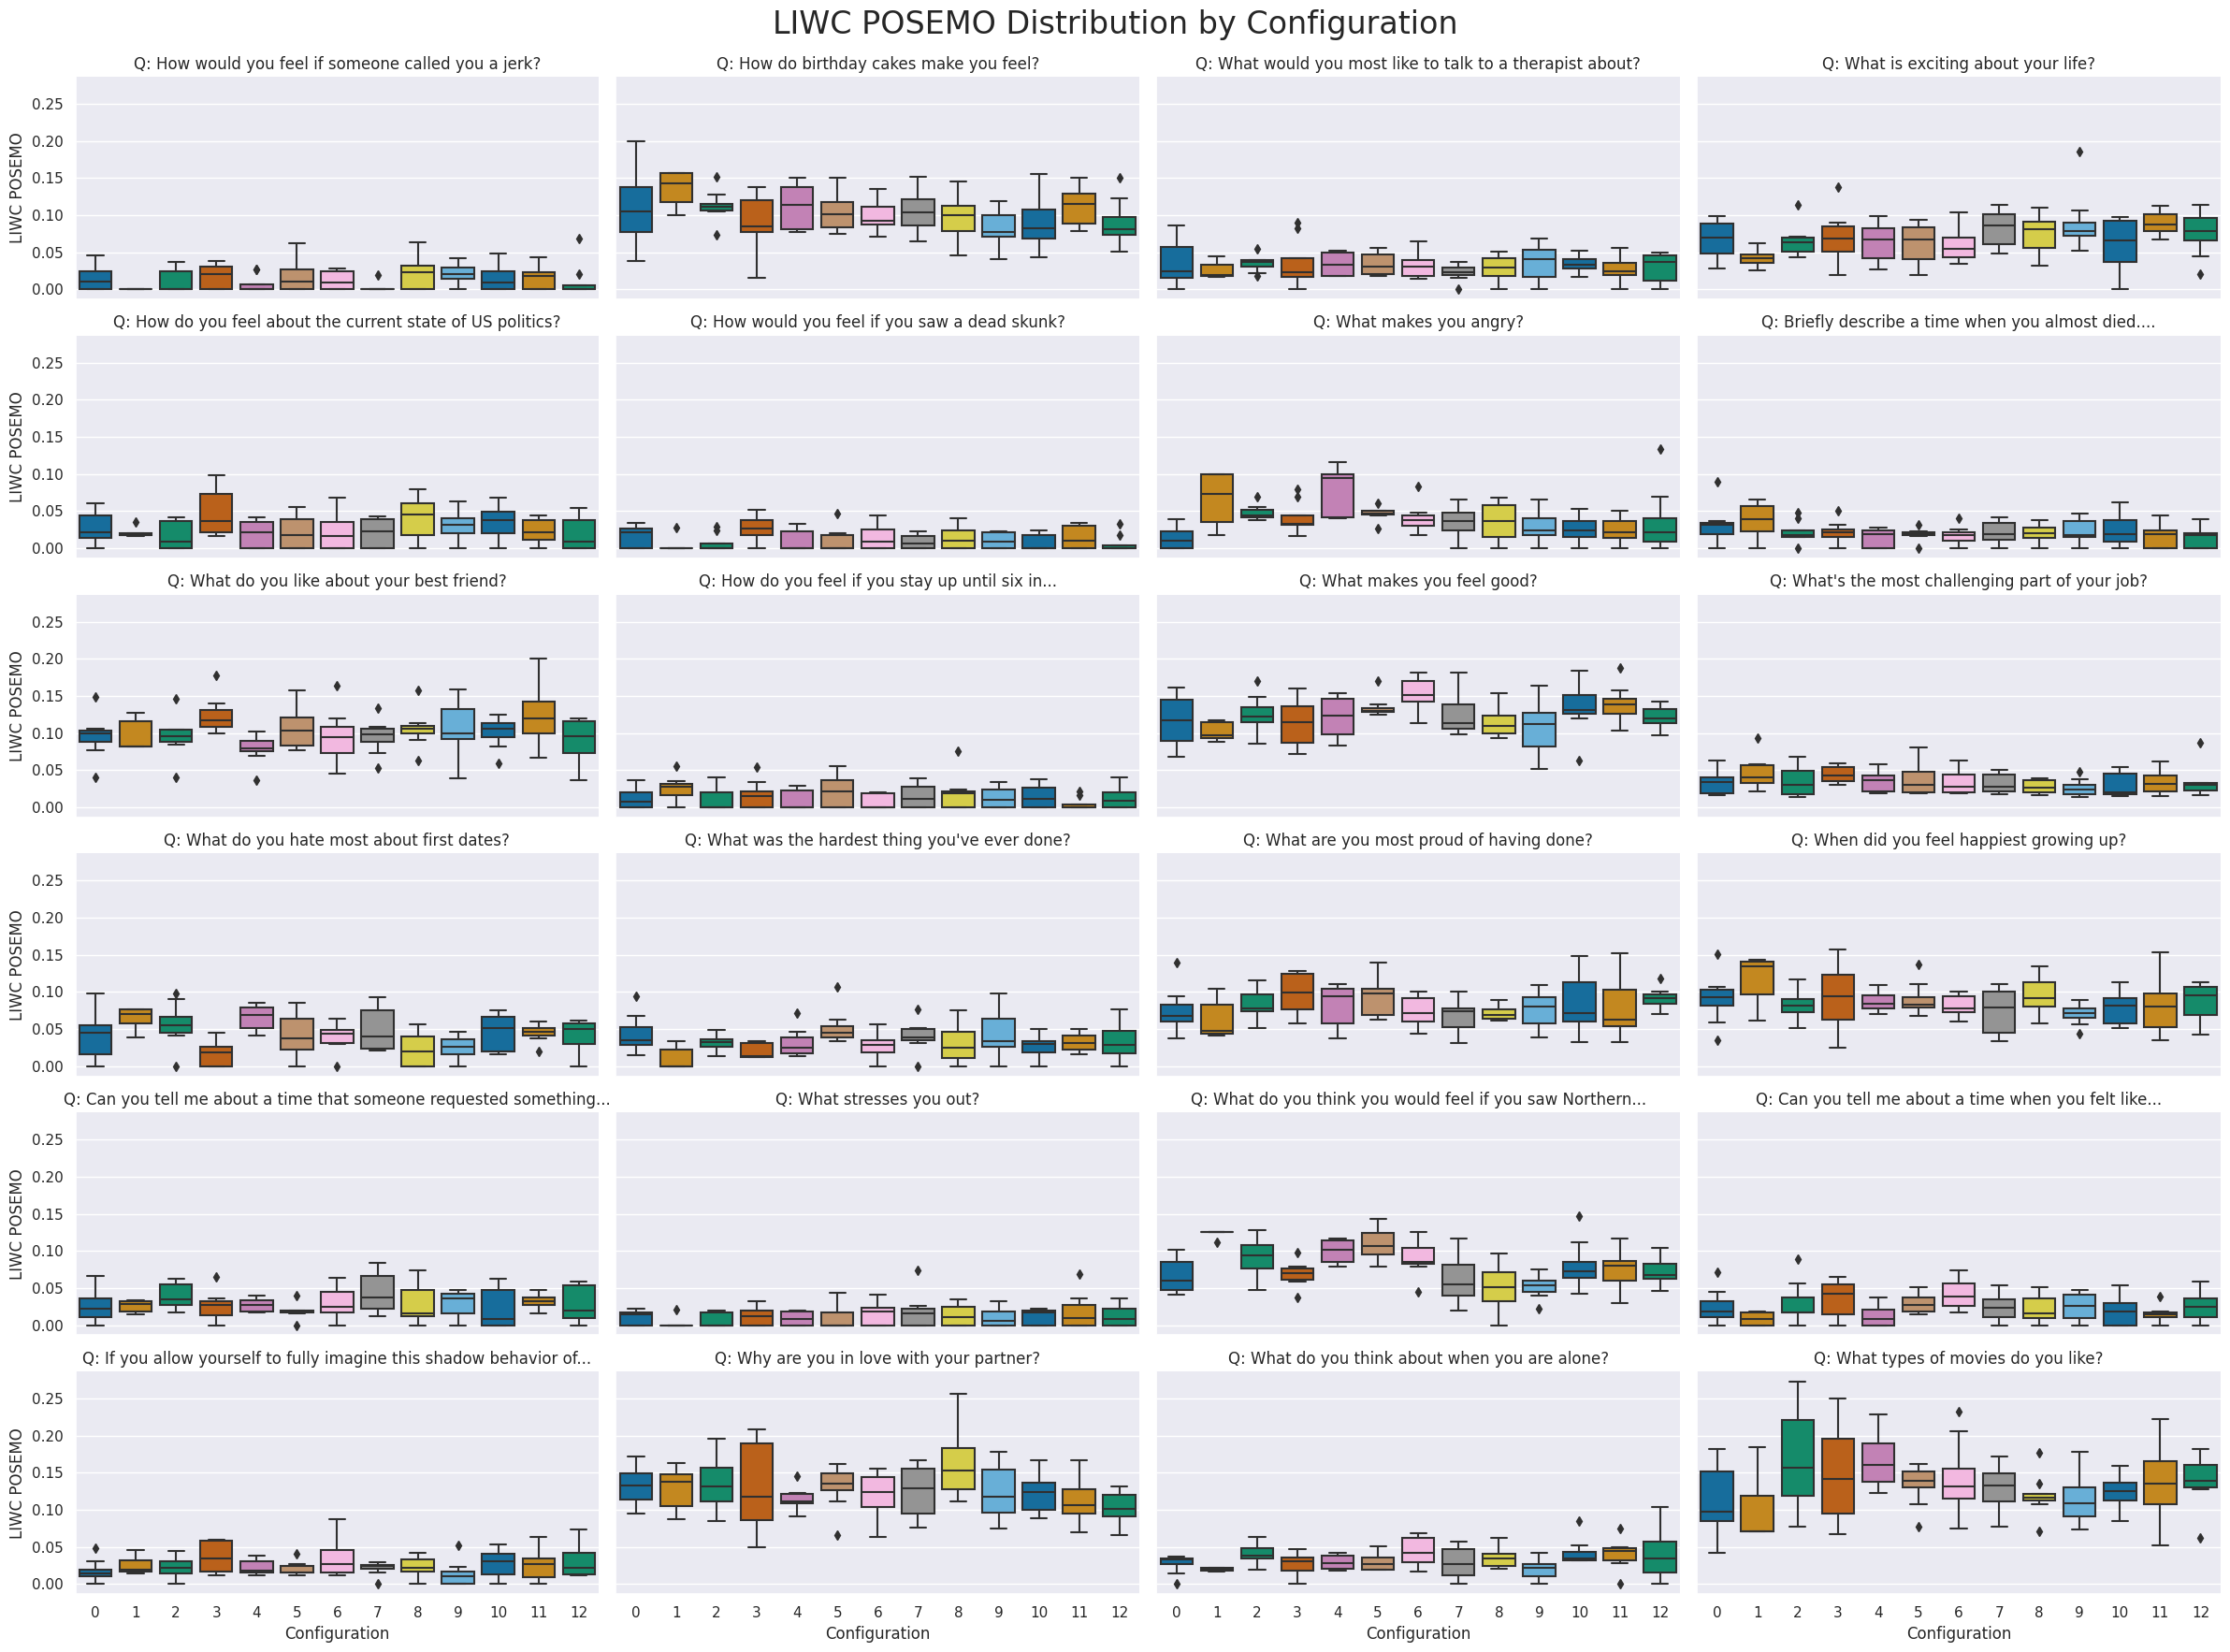

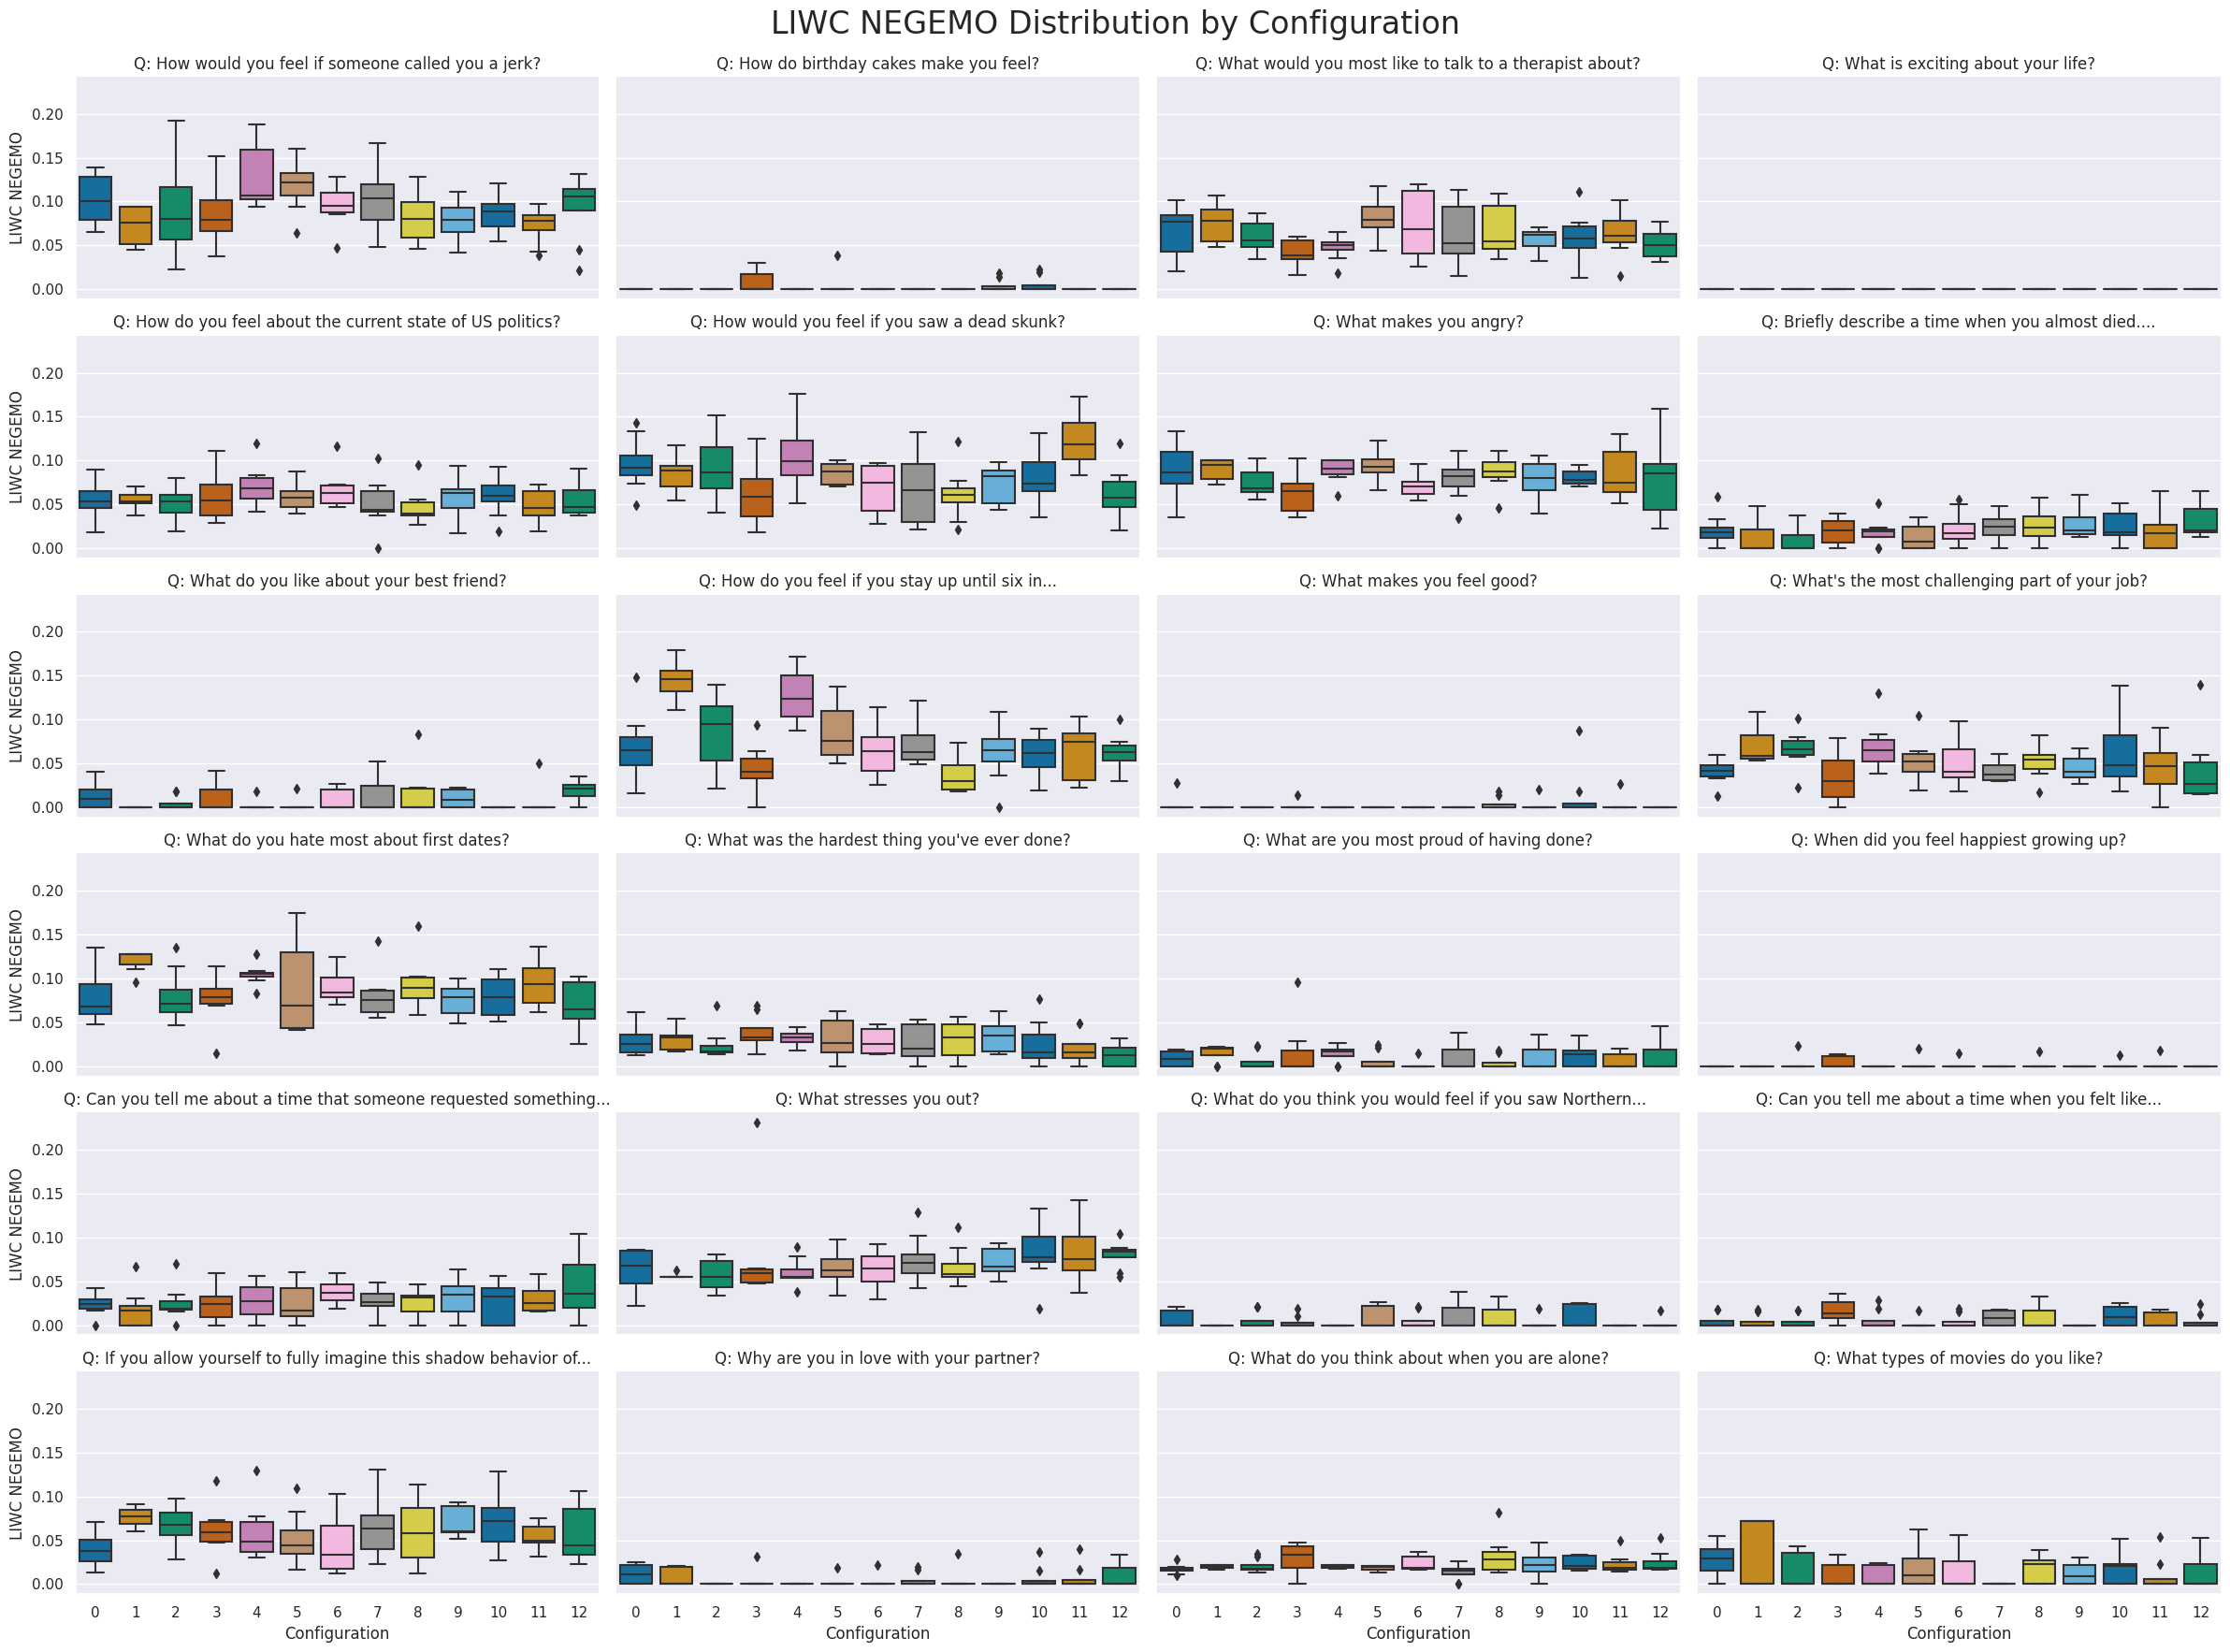

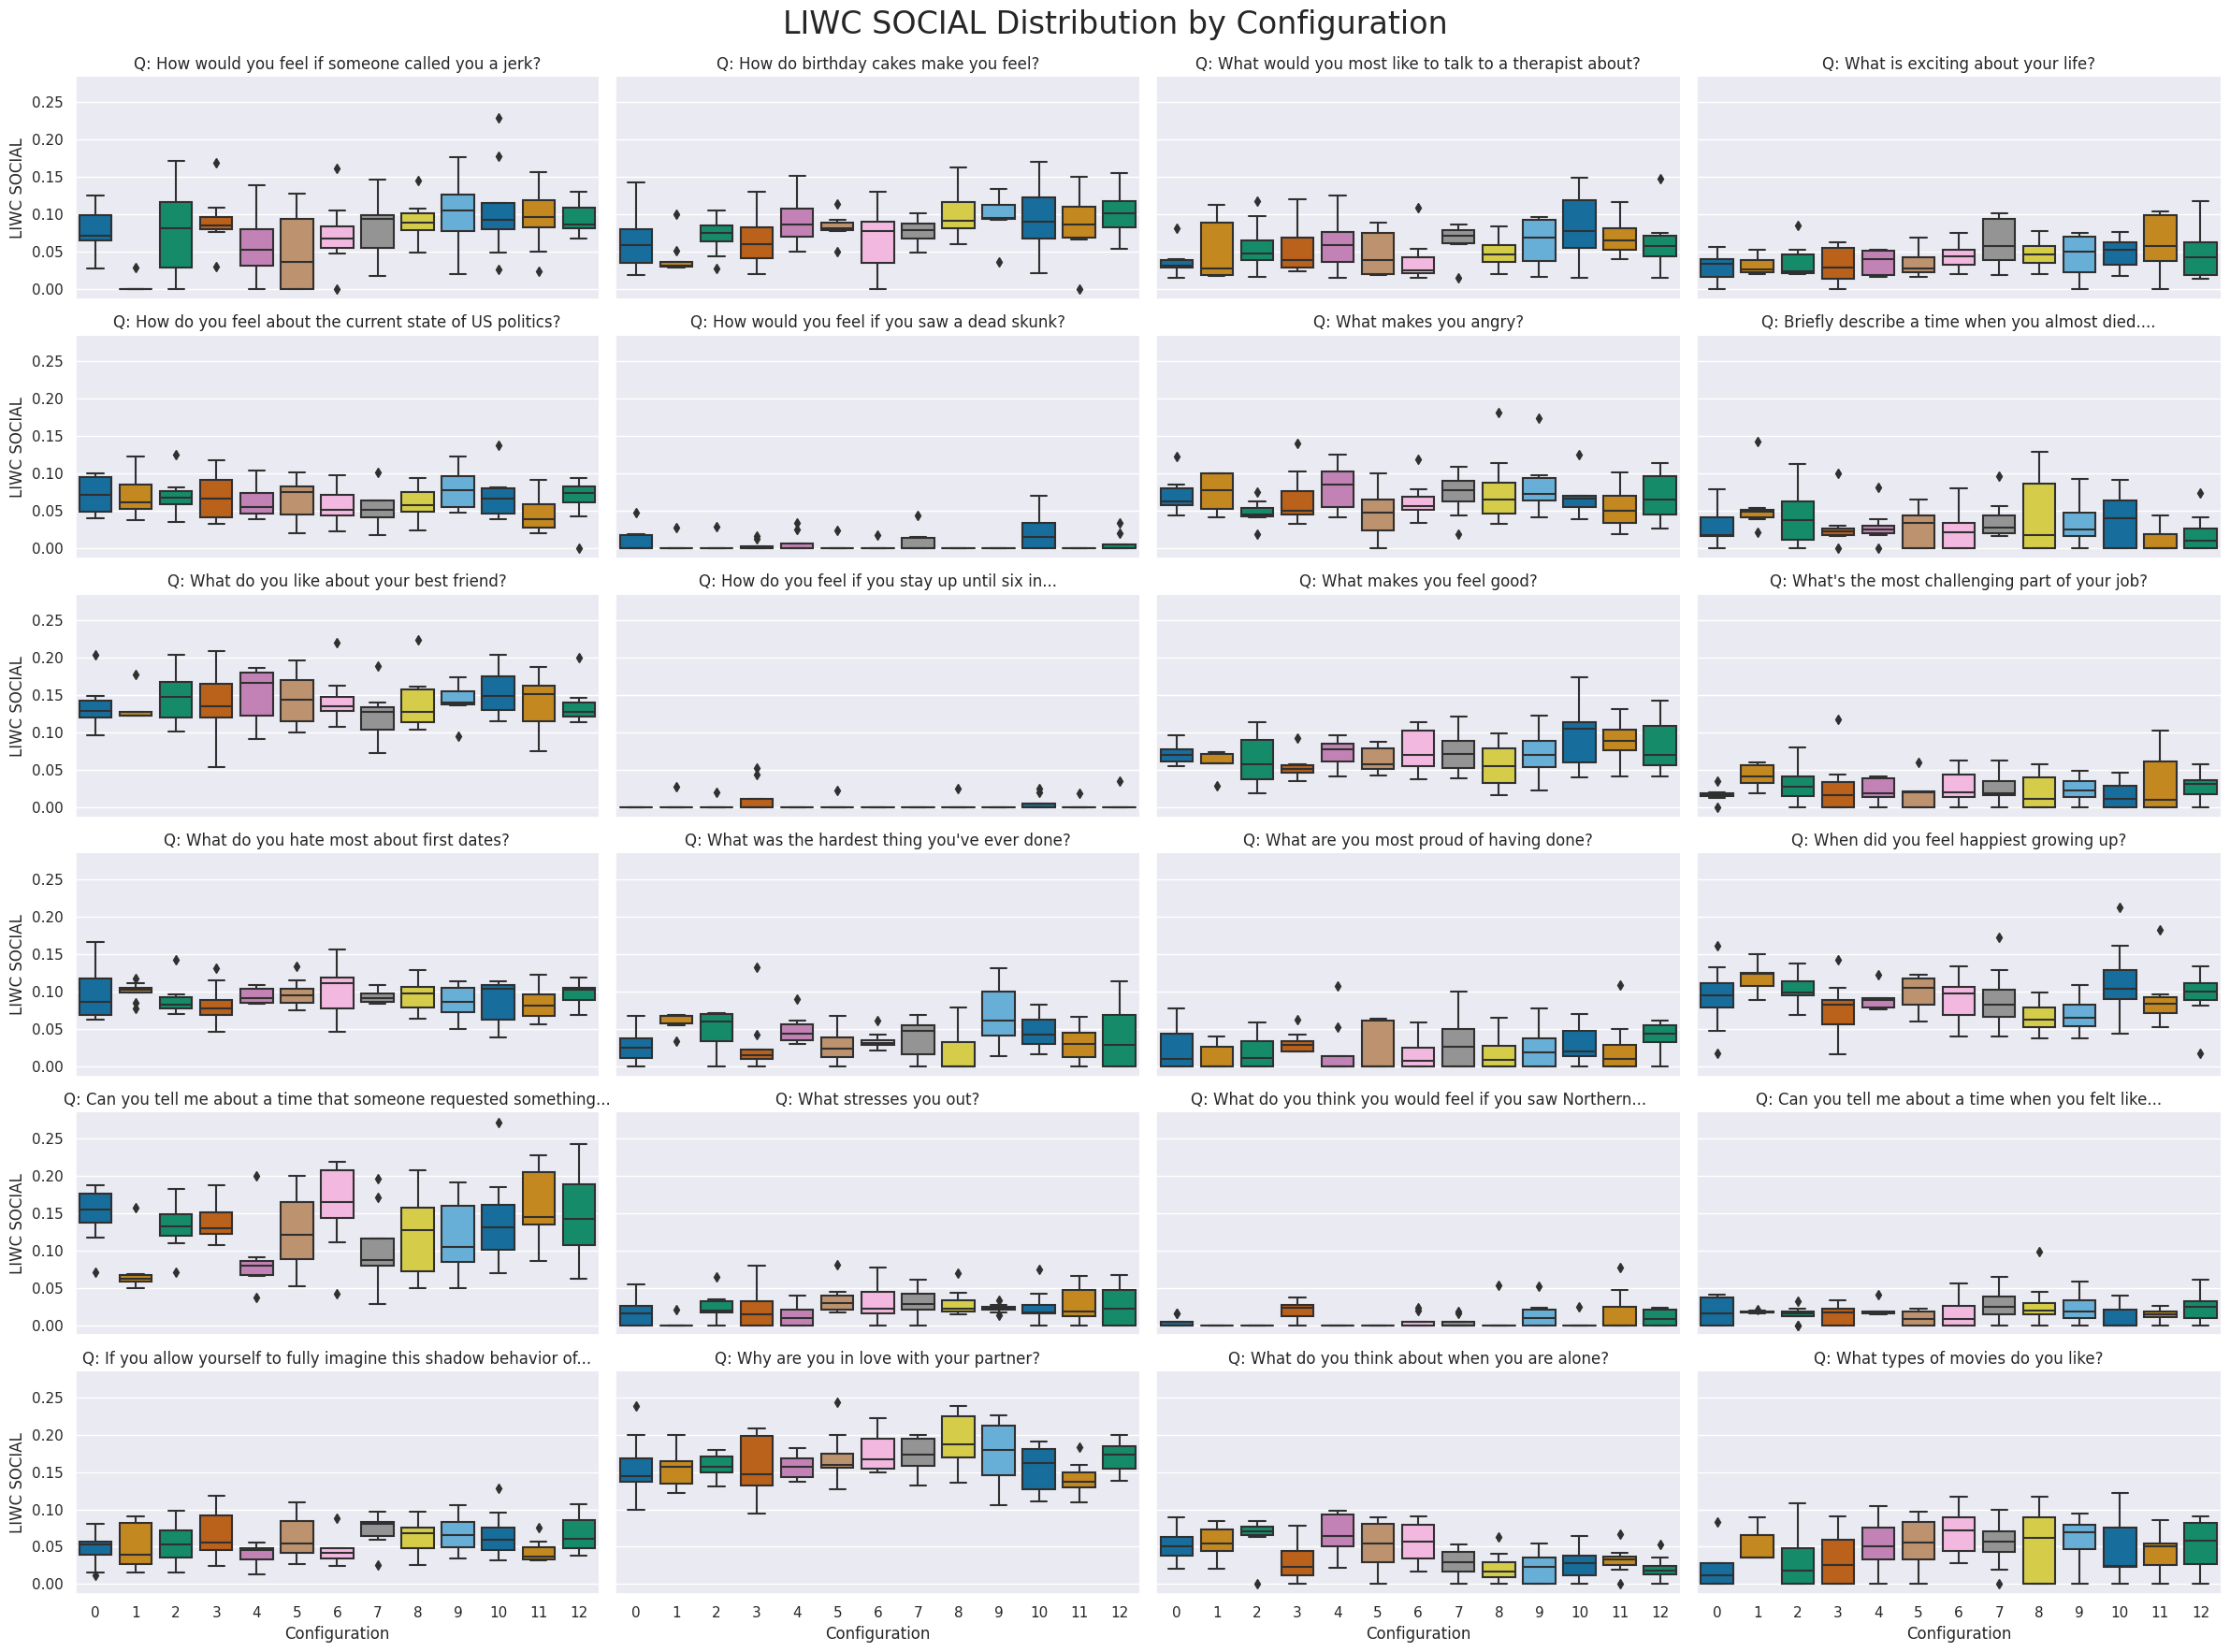

In [11]:
def make_question_title(qid: int, n_tokens: int = 10) -> str:

    text = df_responses.loc[(qid, 0), "question"]
    text = " ".join(text.split()[:n_tokens + 1])
    return text if text.endswith("?") else f"{text}..."


for metric in feat_keep:
    df_liwc_vis = df_liwc_stats[metric] \
                    .reset_index() \
                    .explode(metric) \
                    .assign(question=lambda x: x.qid.apply(make_question_title))
    g = sns.FacetGrid(df_liwc_vis, 
                    col="question", 
                    col_wrap=4, 
                    sharex=True,
                    sharey=True,
                    aspect=2)
    g.map(sns.boxplot, "cid", metric, order=None, palette="colorblind")
    g.set_axis_labels("Configuration", f"LIWC {metric}")
    g.set_titles("Q: {col_name}")
    
    plt.subplots_adjust(top=0.94)
    g.fig.suptitle(f"LIWC {metric} Distribution by Configuration", fontsize=24)
    plt.show()